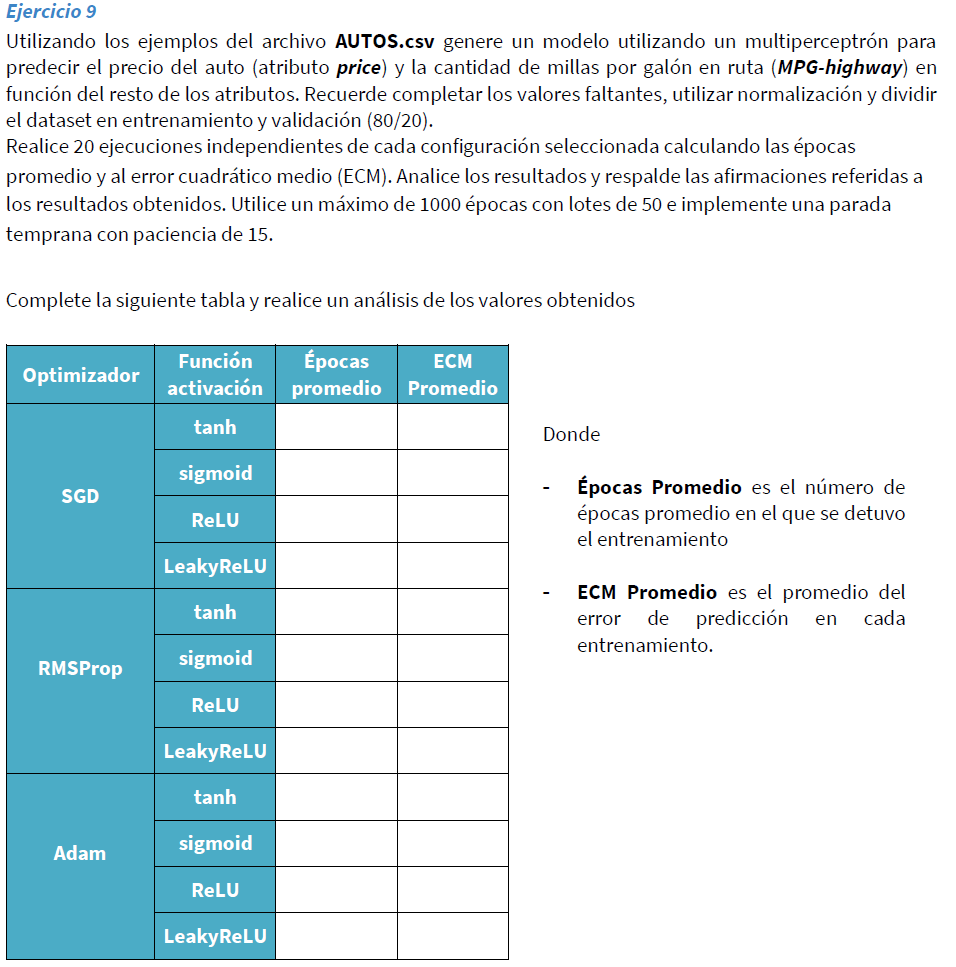

In [5]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [28]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import chardet
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input, LeakyReLU

nombre_archivo = DATOS_DIR + 'AUTOS.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

# visualiza el dataframe

# Para hacer una inspección rápida de los datos
display(df.head(12))
#display(df)

#print(df.describe())
#df['class'].hist(bins=3)
#df['class'].unique()
#-- seleccionar los atributos numéricos --
df = df.select_dtypes(include = ["int16", "int32", "int64", "float16", "float32", "float64"])

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,3
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,3
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2
5,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0,2
6,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0,1
7,NaN,audi,gas,std,four,wagon,fwd,front,105.8,192.7,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0,1
8,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,...,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0,1
9,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,...,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,NaN,0


## Asignar atributos sin valor o con valor nulo

In [29]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
symboling             0
dtype: int64


In [30]:

values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

In [31]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
symboling            0
dtype: int64


## Normalizo atributos y valores a predecir

In [47]:
# Imprime matriz de correclacion
#corr = df.corr()
#plt.figure()
#sns.heatmap(corr, square=True,  annot=True, linewidths=.5)

datos = np.array(df)
normalizarEntrada = 1

attPred = [12,14] #12 mpg-highway y 14 precio  #-- nro de atributos a predecir
T = datos[:, attPred]
X = np.delete(datos, attPred, 1) # elimina columnas de atributos a predecir

if normalizarEntrada:
    data_scaler, target_scaler = StandardScaler(), StandardScaler()
    X = data_scaler.fit_transform(X)
    T = target_scaler.fit_transform(T)


## Construyo modelo

In [100]:
6# cantidad de pasadas de los datos
EPOCAS = 1000
# cantidad de datos a procesar para actualizar pesos
TAM_LOTE = 64

ENTRADAS = X.shape[1]
SALIDAS = len(attPred)

ACTIVACION = LeakyReLU()
#ACTIVACION = 'ReLU'
#ACTIVACION = 'tanh'
#ACTIVACION = 'sigmoid'

#OPTIMIZADOR = 'sgd'
#OPTIMIZADOR = 'rmsprop'
OPTIMIZADOR = 'adam'
PACIENCIA = 15

model = Sequential()
model.add(Input(shape=(ENTRADAS,)))
model.add(Dense(6, activation=ACTIVACION))
model.add(Dense(3, activation= ACTIVACION))
model.add(Dense(SALIDAS))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
model.compile(optimizer=OPTIMIZADOR, loss='mae', metrics = ['accuracy', 'mae', 'mse'])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 6)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119 (476.00 B)

 Trainable params: 119 (476.00 B)

 Non-trainable params: 0 (0.00 B)

## Este no lo use al final

In [89]:
# # %% Separa los datos y clase en grupo de entrenamiento y validacion
# x_train, x_val, y_train, y_val = train_test_split(X, T, test_size = 0.2,  shuffle = True)

# # El parámetro patience indica la cantidad de epocas que deben transcurrir
# # sin mejoras en el entrenamiento
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

# # Entrena el modelo y guarda la historia del progreso
# history = model.fit(x = x_train, y = y_train, batch_size = TAM_LOTE, epochs = EPOCAS,
#               validation_data = (x_val, y_val), callbacks=[early_stop])

# print('\n'+'-'*80)
# print('Epocas utilizadas: %d' % len(history.epoch))

# # %% Evalua e informa resultado de entrenamiento, validación y testeo
# # evalua el modelo con los datos de entreanmiento
# pred = model.evaluate(x_train, y_train, verbose=0)
# print('\nEfectividad del modelo con datos de entrenamiento para:' )
# print(" - Accuracy: %6.2f%%" % (pred[1]*100))
# print(" - Pérdida : %9.5f" % (pred[0]))

# # evalua el modelo con los datos de validacion
# pred = model.evaluate(x_val, y_val, verbose=0)
# print('\nEfectividad del modelo con datos de validacion para:' )
# print(" - Accuracy: %6.2f%%" % (pred[1]*100))
# print(" - Pérdida : %9.5f" % (pred[0]))


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9294 - loss: 0.1959 - mae: 0.1959 - mse: 0.1143 - val_accuracy: 0.9512 - val_loss: 0.2084 - val_mae: 0.2084 - val_mse: 0.1252
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9313 - loss: 0.1946 - mae: 0.1946 - mse: 0.1148 - val_accuracy: 0.9512 - val_loss: 0.2089 - val_mae: 0.2089 - val_mse: 0.1259
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9411 - loss: 0.1970 - mae: 0.1970 - mse: 0.1101 - val_accuracy: 0.9512 - val_loss: 0.2092 - val_mae: 0.2092 - val_mse: 0.1260
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9313 - loss: 0.1986 - mae: 0.1986 - mse: 0.1164 - val_accuracy: 0.9512 - val_loss: 0.2097 - val_mae: 0.2097 - val_mse: 0.1261
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9352 - loss: 0.2069 - mae: 0.2069 - mse: 0.1223 - val_accuracy: 0.9512 - val_loss: 0.2102 - val_mae: 0.2102 - val_mse: 0.1264
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

## Entrenamiento del modelo con parada temprana

In [106]:
# ITERA = 10
# cant_epocas = []
# ECMs_train = []
# ECMs_validation = []
# accuracy_train = []
# accuracy_validation = []
# loss_train = []
# loss_validation = []

# El parámetro patience indica la cantidad de epocas que deben transcurrir
# sin mejoras en el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

# for i in range(ITERA):
    # %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(X, T, test_size = 0.2,  shuffle = True)

# Entrena el modelo y guarda la historia del progreso
history = model.fit(x = x_train, y = y_train, batch_size = TAM_LOTE, epochs = EPOCAS,
            validation_data = (x_val, y_val), callbacks=[early_stop])

    
    # evalua el modelo con los datos de entreanmiento
#     pred = model.evaluate(x_train, y_train, verbose=0)
#     ECMs_train.append(pred[2])
#     loss_train.append(pred[0])
#     accuracy_train.append(pred[1])

#     # evalua el modelo con los datos de validacion
#     pred = model.evaluate(x_val, y_val, verbose=0)
    # ECMs_validation.append(pred[2])
#     loss_validation.append(pred[0])
#     accuracy_validation.append(pred[1])
    

#     cant_epocas.append(len(history.epoch))

# ECMs_train_average = np.mean(ECMs_train)
# ECMs_validation_average = np.mean(ECMs_validation)
# loss_train_average = np.mean(loss_train)
# loss_validation_average = np.mean(loss_validation)
# accuracy_train_average = np.mean(accuracy_train)
# accuracy_validation_average = np.mean(accuracy_validation)



Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9811 - loss: 0.1968 - mae: 0.1968 - mse: 0.1286 - val_accuracy: 0.9756 - val_loss: 0.1740 - val_mae: 0.1740 - val_mse: 0.1000
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9830 - loss: 0.1991 - mae: 0.1991 - mse: 0.1363 - val_accuracy: 0.9756 - val_loss: 0.1743 - val_mae: 0.1743 - val_mse: 0.1000
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9772 - loss: 0.1989 - mae: 0.1989 - mse: 0.1263 - val_accuracy: 0.9756 - val_loss: 0.1748 - val_mae: 0.1748 - val_mse: 0.1004
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9889 - loss: 0.1956 - mae: 0.1956 - mse: 0.1256 - val_accuracy: 0.9756 - val_loss: 0.1749 - val_mae: 0.1749 - val_mse: 0.1004
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9869 - loss: 0.1971 - mae: 0.1971 - mse: 0.1284 - val_accuracy: 0.9756 - val_loss: 0.1750 - val_mae: 0.1750 - val_mse: 0.1002
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms

In [107]:
# %% Evalua e informa resultado de entrenamiento, validación y testeo
# evalua el modelo con los datos de entreanmiento
pred = model.evaluate(x_train, y_train, verbose=0)
print('\nEfectividad del modelo con datos de entrenamiento para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))

# evalua el modelo con los datos de validacion
pred = model.evaluate(x_val, y_val, verbose=0)
print('\nEfectividad del modelo con datos de validacion para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))


Efectividad del modelo con datos de entrenamiento para:
 - Accuracy:  98.17%
 - Pérdida :   0.20548

Efectividad del modelo con datos de validacion para:
 - Accuracy:  97.56%
 - Pérdida :   0.17402


## Ver info

In [80]:
# # Crear un diccionario donde las claves son los nombres de las columnas
# datos = {
#     'Iteración': list(range(1, ITERA + 1)),
#     'cant_epocas': cant_epocas,
#     'ECMs_train': ECMs_train,
#     'ECMs_validation': ECMs_validation,
#     'accuracy_train': accuracy_train,
#     'accuracy_validation': accuracy_validation,
#     'loss_train': loss_train,
#     'loss_validation': loss_validation
# }
# # Crear el DataFrame a partir del diccionario
# tabla_resultados = pd.DataFrame(datos)

# # Calcular los promedios de cada columna (excepto 'Iteración')
# promedios = {
#     'Iteración': 'Promedio',
#     'cant_epocas': np.mean(cant_epocas),
#     'ECMs_train': np.mean(ECMs_train),
#     'ECMs_validation': np.mean(ECMs_validation),
#     'accuracy_train': np.mean(accuracy_train),
#     'accuracy_validation': np.mean(accuracy_validation),
#     'loss_train': np.mean(loss_train),
#     'loss_validation': np.mean(loss_validation)
# }

# # Crear un DataFrame para los promedios
# promedios_df = pd.DataFrame([promedios])

# # Concatenar el DataFrame original con la fila de promedios
# tabla_resultados = pd.concat([tabla_resultados, promedios_df], ignore_index=True)

# tabla_resultados

,Iteración,cant_epocas,ECMs_train,ECMs_validation,accuracy_train,accuracy_validation,loss_train,loss_validation
0,1,16.0,0.202480,0.190265,0.914634,0.975610,0.202480,0.190265
1,2,15.0,0.195468,0.218735,0.908537,1.000000,0.195468,0.218735
2,3,15.0,0.198827,0.204873,0.920732,0.951219,0.198827,0.204873
3,4,16.0,0.206855,0.172814,0.920732,0.951219,0.206855,0.172814
4,5,15.0,0.192194,0.230666,0.939024,0.878049,0.192194,0.230666
5,6,16.0,0.213202,0.146530,0.914634,0.975610,0.213202,0.146530
6,7,15.0,0.198896,0.203203,0.932927,0.902439,0.198896,0.203203
7,8,15.0,0.178046,0.286929,0.920732,0.951219,0.178046,0.286929
8,9,15.0,0.186781,0.251669,0.932927,0.902439,0.186781,0.251669
9,10,15.0,0.200220,0.197175,0.951219,0.829268,0.200220,0.197175


## Graficos con evolucion de curvas de error y graficos

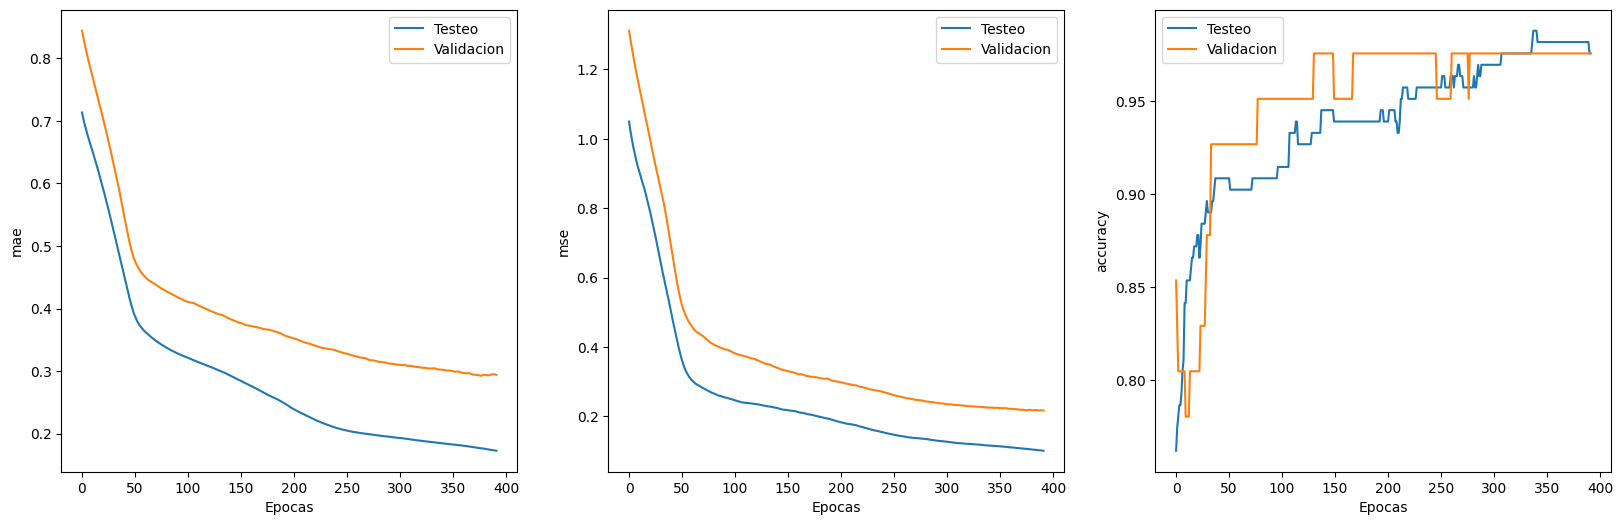

In [102]:
hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,3, figsize=(20,6))

dibujar_curva(axs[0], 'mae', history.epoch, hist)
dibujar_curva(axs[1], 'mse', history.epoch, hist)
dibujar_curva(axs[2], 'accuracy', history.epoch, hist)